Author: Carlos Roberto de Melo
    
Date: 08/01/2020

Obj: Parametrizar o perfil NFW elípticco. A parametrização é feita com gaussianas, de modo que possam ser adicionadas ao potencial do JAM mais tarde. A forma funcional do modelo NFW elíptico é:
    $\frac{\rho_s}{(r/r_s)(1 + r/r_s)²}$. Mas neste caso, a coordenada $R$ no densidade projetada é substituida por $R² = x² + y²/q²$, em que $q$ é o axial ratio.
    
O modelo pode ainda ser parametrizado em termos de uma constante adimensional $\kappa_s$ que se relaciona da seguinte forma com as constantes acima:

$\kappa_s = \frac{\rho_s r_s}{\Sigma_{crit}}$
    
em que $\Sigma_{crit}$ é a densidade superficial crítica da teoria de lentes.

In [1]:
from mgefit import mge_fit_1d
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, c, M_sun

In [2]:
#Lens parameters

z_lens = 0.035
z_source = 2.1

D_l = cosmo.angular_diameter_distance(z_lens)
D_s = cosmo.angular_diameter_distance(z_source)
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s
G_pc = G_Mpc*(1e6**3/u.Mpc**3)*u.pc**3      #Gravitational constant in pc³/(Msun s²)

SQRT_TOW_PI = np.sqrt(2*np.pi)              #Square root of 2pi

#NFW parameters
kappa_s = 3                                                     #Admensional
rs_arc = 0.5*u.arcsec                                           #Scale radius in arcsec
rs_pc = (rs_arc * D_l).to(u.pc, u.dimensionless_angles())       #Scale radius in pc

crit_density_Mpc = (D_s*c_Mpc**2)/(4*np.pi*G_Mpc*D_ls*D_l)      #Critical density in Msun/Mpc²
crit_density_pc = (crit_density_Mpc)*((u.Mpc**2)/(1e6*u.pc)**2) #Critical density in Msun/pc²

rho_s = (crit_density_pc*kappa_s)/rs_pc                         #Density at r = rs of Spherical NFW in Msun/pc³

In [3]:
#Perfil Spherical NFW
def SphNFW(rho_s, r_s, r):
    """
    rho_s: float
        Density at r = rs in the Spherical NFW model. [Msun/pc³]
    r_s: float
        Scale radius of the Spherical NFW model. [pc]
    r: array
        Radius in logscale where do you want parametrize the model. [log(pc)]     
    """
    rho = rho_s/((r/r_s)*(1 + r/r_s)**2)
    print(rho.unit)
    return rho.value

#Realializa a deprojeção de 2d para 3d das gaussianas. Isso assume uma certa parametrização mge2d, um ângulo
    #de inclinação para deprojeção e um formato (oblate ou prolate)
def deprojection(mge2d, inc, shape):
        '''
        Return the 3D deprojected MGE coefficients
        '''
        mge3d = np.zeros_like(mge2d)
        if shape == 'oblate':
            qintr = mge2d[:, 2]**2 - np.cos(inc)**2
            if np.any(qintr <= 0):
                raise RuntimeError('Inclination too low q < 0')
            qintr = np.sqrt(qintr)/np.sin(inc)
            if np.any(qintr < 0.05):
                raise RuntimeError('q < 0.05 components')
            dens = mge2d[:, 0]*mge2d[:, 2] /\
                (mge2d[:, 1]*qintr*SQRT_TOW_PI)
            mge3d[:, 0] = dens
            mge3d[:, 1] = mge2d[:, 1]
            mge3d[:, 2] = qintr
        elif shape == 'prolate':
            qintr = np.sqrt(1.0/mge2d[:, 2]**2 -
                            np.cos(inc)**2)/np.sin(inc)
            if np.any(qintr > 10):
                raise RuntimeError('q > 10.0 conponents')
            sigmaintr = mge2d[:, 1]*mge2d[:, 2]
            dens = mge2d[:, 0] / (SQRT_TOW_PI*mge2d[:, 1] *
                                       mge2d[:, 2]**2*qintr)
            mge3d[:, 0] = dens
            mge3d[:, 1] = sigmaintr
            mge3d[:, 2] = qintr
        return mge3d


#Calcula a densidade luminosa de gaussianadas 3d para algum raio R
def luminosityDensity(mge3d, R, z):
        '''
        Return the luminosity density at coordinate R, z (in L_solar/pc^3)
        '''
        rst = 0.0
        ngauss = mge3d.shape[0]
        for i in range(ngauss):
            rst += mge3d[i, 0] * np.exp(-0.5/mge3d[i, 1]**2 *
                                        (R**2 + (z/mge3d[i, 2])**2))
        return rst

solMass / pc3
solMass / pc3


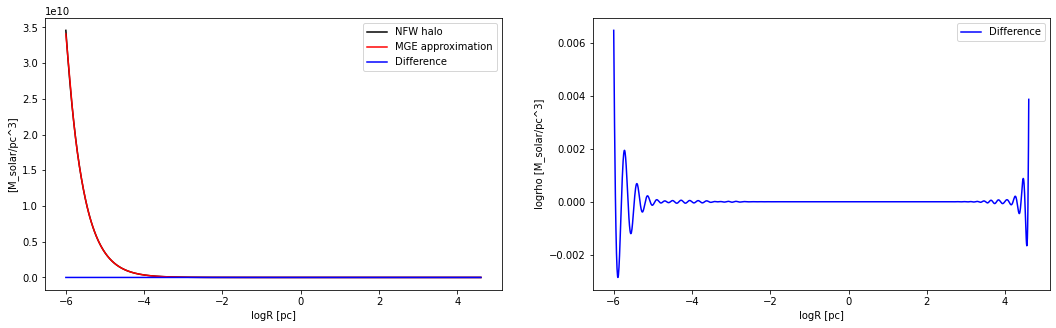

In [4]:
#Main code

r = np.logspace(np.log10(1e-6), np.log10(4e4), 1500)*u.pc #Cria valores espaçados em de um delta-log (requerido para o mge1d_fit). Unidade de pc
logr = np.log10(r.value)                                   #"Unidade de pc"

#Calculando o perfil SphericalNFW analítico e tomando o log para posterior plot
profile_NFW = np.log10(SphNFW(rho_s=rho_s, r_s=rs_pc, r=r))   #M_sun/pc³ 

#Agora vamos realizar a parametrização em MGE 1d
r_mge2d = np.logspace(np.log10(1e-6), np.log10(4e4), 1500)*u.pc #Cria valores espaçados em de um delta-log (requerido para o mge1d_fit)
rho_mge2d = SphNFW(rho_s=rho_s, r_s=rs_pc, r=r_mge2d) #Perfil SphericalNFW

#-------------Aqui é onde realmente começa a parametrização MGE--------------------------------

mge = mge_fit_1d.mge_fit_1d(r_mge2d.value, rho_mge2d, quiet=True, ngauss=100)
mge_peak = mge.sol[0]         #Pico de cada gaussiana
mge_sigma = mge.sol[1]        #Sigma de cada gaussiana
#O resultado acima já está em M_sun/pc²

mge2d = np.zeros((len(mge_peak), 3)) #Agora iremos criar um array com o número de linhas igual ao número de
                                        #gaussianas e três colunas para armazenar os dados
mge2d[:, 0] = mge_peak     #Pico de cada gaussiana
mge2d[:, 1] = mge_sigma    #Sigma de cada gausiana
mge2d[:, 2] = 0.80         #qObs de cada gaussiana. 



#--------------A partir daqui vamos apenas comparar o perfil analítico com o perfil parametrizado. Em princípio
    #o necessário para o modelo JAM termina acima e só é necessário salvar os dados. ----------------------------#
#Here are some unit conversion
mge3d = deprojection(mge2d=mge2d, inc=np.pi/2, shape='oblate')#Deprojeta o perfil 2d para 3d assumindo uma inclinação inc e um formato do elipsoide de velocidades 
mge_density = luminosityDensity(mge3d,r.value,0) #Densidade das MGE deprojetadas. Atenção as unidades de medida.

#Finalmente o perfil DM parametrizado pelo MGE.
profile_mge = np.log10(mge_density)#Aqui voltamos a multiplicar por 1e9 pois queremos comparar com o outro perfil, que tem unidades [M_sol/pc³]

# plot the density profile of the dark halo and the mge approximation

plt.figure(figsize=(18,5))
plt.subplot(121)
line_dh, = plt.plot(logr, 10**profile_NFW, 'k')
line_mge, = plt.plot(logr, 10**profile_mge, 'r')
diff, = plt.plot(logr, profile_NFW-profile_mge, 'b', scalex=200)
plt.xlabel('logR [pc]')
plt.ylabel('[M_solar/pc^3]')
plt.legend([line_dh, line_mge, diff], ['NFW halo', 'MGE approximation', 'Difference'])


plt.subplot(122)
diff, = plt.plot(logr, profile_NFW-profile_mge, 'b', scalex=200)
plt.xlabel('logR [pc]')
plt.ylabel('logrho [M_solar/pc^3]')
plt.legend([diff], ['Difference'])

plt.subplots_adjust(wspace=0.2)
plt.savefig('/home/carlos/autolens_workspace/howtolens/Testes with MGE/Elliptical NFW/Image Output/NFW MGE and Analitic', fmt='png')

plt.show()


In [5]:
np.savetxt('EllipticalNFW MGE.txt', np.column_stack([mge2d[:, 0], mge2d[:,1]/(D_l.value*np.pi/0.648),mge2d[:,2]]),
                            fmt=b'%10.6f\t\t %e %10.6f', 
                            header='Surface Potential(M_sun/pc²) Sigma Potential(arcsec) qObs')

#Aqui, quando salvamos o sigma de cada gaussiana dividimos pelo valor (D_l*np.pi/0.648) para termos o valor em arcsec 